# Inspection angle span wrt 7m range threshold: AR=1.3

Note in this notebook we did not use `df_summary["TRIAL_TO_INCLUDE"]` to exclude unusable trials, because none of the unusable trials were included in the clustering analysis.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load clustering results

In [7]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [8]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [9]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [10]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [11]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [12]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [13]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [14]:
CLUSTER_STR_7 = ["Straight", "Curved-1", "Curved-2", "Straight", "Curved-1", "Curved-2"]

## Gather data for inspection angle span before/after range threshold

- Range threshold: the elliptical distance from DTAG to both targets.
- Decision time: last click in the last scan to non-chosen target

Cases:
- before range threshold
- after range threshold but _before_ last inspection
- after range threshold but _including_ last inspection

In [15]:
# Range threshold
th_range = 7  # [m]

In [16]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Function

In [17]:
def get_angle_span_single_trial(trial_idx, filter_func):
    """
    Filter clicks and get angle span for a single trial.
    
    filter_func: one of the following:
        - filter_clicks_far
        - filter_clicks_close
        - filter_clicks_close_before_last_scan
    """
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)

    # Time when animal reaching range threshold
    time_range_th = utils.get_time_range_threshold(
        df_tr=tp.df_track.dropna(subset=["DTAG_dist_elliptical"]).copy(),
        th_range=th_range
    )

    # Filter clicks
    # time_last_scan_start is only used for filter_clicks_close_before_last_scan
    # time_far_start is only used for filter_clicks_far
    df_ch0 = filter_func(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_last_scan_start=tp.last_scan_start,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )
    df_ch1 = filter_func(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_last_scan_start=tp.last_scan_start,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )

    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")

    # Return inspection angle range
    return (
        df_ch0["enso_angle"].dropna().max() - df_ch0["enso_angle"].dropna().min(),
        df_ch1["enso_angle"].dropna().max() - df_ch1["enso_angle"].dropna().min()
    )

### Buzz onset before decision time: trials to be plotted as "x"

In [18]:
# All trial index that should be plotted as "x"
idx_cross_all = df_summary[df_summary["time_buzz_onset_clean"] < df_summary["time_decision"]].index

### Filter clicks > 7m elliptical distance

In [19]:
%%time
ch0_span_all_far_7 = []
ch1_span_all_far_7 = []
for c_seq, df_c in enumerate(df_cluster_clean_7):
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_far
        )
    
    ch0_span_all_far_7.append(ch0_span)
    ch1_span_all_far_7.append(ch1_span)

CPU times: user 157 ms, sys: 33.4 ms, total: 191 ms
Wall time: 282 ms


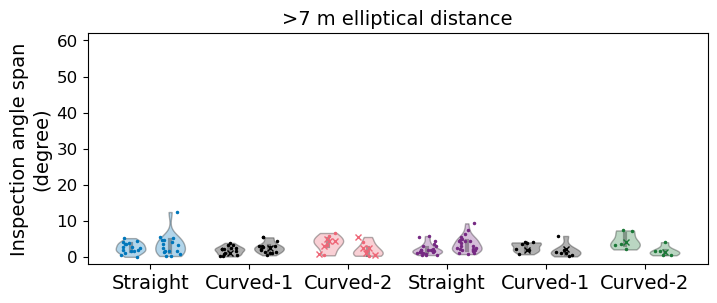

In [20]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(df_cluster_clean_7)),
    ch0_span_all_far_7,
    ch1_span_all_far_7,
    color_cluster_7.keys(),
    color_cluster_7.values()
):
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_cluster_clean_7[c_seq].index.isin(idx_cross_all)
    val_idx_dot = ~df_cluster_clean_7[c_seq].index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )
    
    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(CLUSTER_STR_7, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 62)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title(">7 m elliptical distance", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance

In [21]:
%%time
ch0_span_all_close_7 = []
ch1_span_all_close_7 = []
for c_seq, df_c in enumerate(df_cluster_clean_7):
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_close
        )

    ch0_span_all_close_7.append(ch0_span)
    ch1_span_all_close_7.append(ch1_span)

Trial 96: df_ch0 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 134: df_ch0 is empty
CPU times: user 212 ms, sys: 47.3 ms, total: 259 ms
Wall time: 316 ms


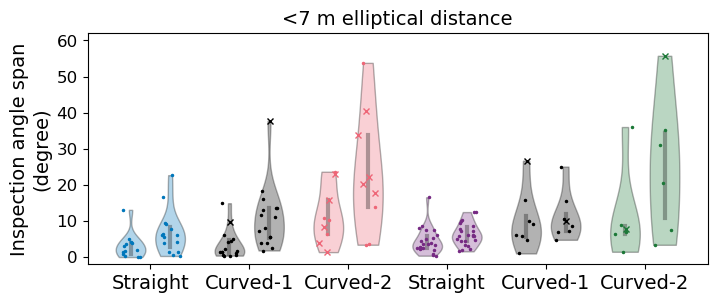

In [22]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(df_cluster_clean_7)),
    ch0_span_all_close_7,
    ch1_span_all_close_7,
    color_cluster_7.keys(),
    color_cluster_7.values()
):
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_cluster_clean_7[c_seq].index.isin(idx_cross_all)
    val_idx_dot = ~df_cluster_clean_7[c_seq].index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(CLUSTER_STR_7, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 62)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)

axx.set_title("<7 m elliptical distance", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance but before last scan

In [23]:
%%time
ch0_span_all_close_7_before_last_scan = []
ch1_span_all_close_7_before_last_scan = []
for c_seq, df_c in enumerate(df_cluster_clean_7):
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_close_before_last_scan
        )

    ch0_span_all_close_7_before_last_scan.append(ch0_span)
    ch1_span_all_close_7_before_last_scan.append(ch1_span)

Trial 96: df_ch0 is empty
Trial 96: df_ch1 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 134: df_ch0 is empty
Trial 134: df_ch1 is empty
Trial 132: df_ch1 is empty
Trial 89: df_ch1 is empty
Trial 186: df_ch0 is empty
Trial 186: df_ch1 is empty
Trial 190: df_ch1 is empty
Trial 192: df_ch1 is empty
CPU times: user 172 ms, sys: 23.4 ms, total: 196 ms
Wall time: 211 ms


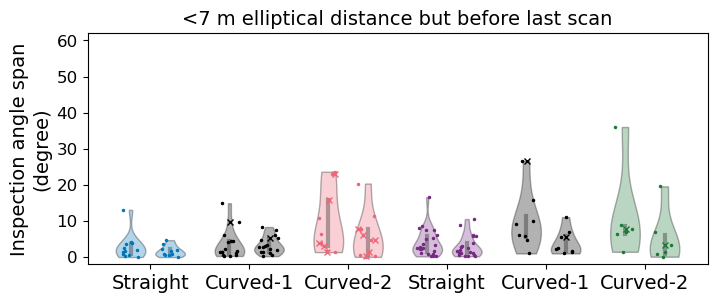

In [24]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(df_cluster_clean_7)),
    ch0_span_all_close_7_before_last_scan,
    ch1_span_all_close_7_before_last_scan,
    color_cluster_7.keys(),
    color_cluster_7.values()
):
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_cluster_clean_7[c_seq].index.isin(idx_cross_all)
    val_idx_dot = ~df_cluster_clean_7[c_seq].index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0,
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1,
        color=c_color, width=0.2, marker=".", markersize=3, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(CLUSTER_STR_7, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 62)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)

axx.set_title("<7 m elliptical distance but before last scan", fontsize=14)
    
plt.show()

## Put panels together

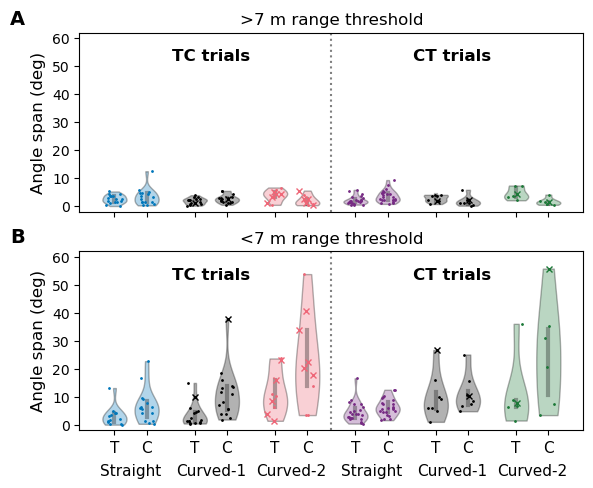

In [25]:
plot_track_opt = True  # set to False for quickly tuning fig


fig, ax = plt.subplots(2, 1, figsize=(6.5, 5), facecolor="w")

plt.subplots_adjust(hspace=0.15)


# =================================
# Inspection angle span > 7m
# =================================
ax_angle_far = ax[0]

for c_seq, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(df_cluster_clean_7)), ch0_span_all_far_7, ch1_span_all_far_7,
    color_cluster_7.keys(), color_cluster_7.values()
):
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_cluster_clean_7[c_seq].index.isin(idx_cross_all)
    val_idx_dot = ~df_cluster_clean_7[c_seq].index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax_angle_far, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax_angle_far, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=2, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax_angle_far, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

    # Ch1
    utils_plot.plot_vio(
        axx=ax_angle_far, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax_angle_far, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=2, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax_angle_far, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )


# =================================
# Inspection angle span < 7m
# =================================
ax_angle_close = ax[1]

for c_seq, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(df_cluster_clean_7)), ch0_span_all_close_7, ch1_span_all_close_7,
    color_cluster_7.keys(), color_cluster_7.values()
):
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_cluster_clean_7[c_seq].index.isin(idx_cross_all)
    val_idx_dot = ~df_cluster_clean_7[c_seq].index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax_angle_close, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax_angle_close, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=2, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax_angle_close, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )

    # Ch1
    utils_plot.plot_vio(
        axx=ax_angle_close, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=0.3, qbar_color="k", qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        axx=ax_angle_close, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color=c_color, width=0.2, marker=".", markersize=2, alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax_angle_close, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color=c_color, width=0.2, marker="x", markersize=5, alpha=1
    )
    
# Axes setup
for axx in [ax_angle_far, ax_angle_close]:
    axx.set_xticks(sorted(np.hstack((np.arange(6)-0.2, np.arange(6)+0.2))))
    axx.set_xticklabels("")
    axx.set_yticks(np.arange(0, 65, 10))
    axx.set_yticklabels(np.arange(0, 65, 10), fontsize=10)
    axx.set_ylim(-2, 62)
    axx.set_ylabel("Angle span (deg)", fontsize=12)
    axx.axvline(2.5, color="grey", ls=":")
    axx.text(1, 52, "TC trials", fontsize=12,  fontweight="bold", ha="center")
    axx.text(4, 52, "CT trials", fontsize=12,  fontweight="bold", ha="center")
ax_angle_close.set_xticklabels(["T", "C"] * 6, fontsize=11)

for xloc in range(6):
    ax_angle_close.text(xloc, -18, CLUSTER_STR_7[xloc], fontsize=11, ha="center")

    
ax_angle_far.set_title(">7 m range threshold", fontsize=12)
ax_angle_close.set_title("<7 m range threshold", fontsize=12)

# Adjust bottom 2 axes vertical location
ax_pos = ax_angle_far.get_position()
ax_angle_far.set_position([
    ax_pos.x0, ax_pos.y0-ax_pos.height*0.07, ax_pos.width, ax_pos.height
])
ax_pos = ax_angle_close.get_position()
ax_angle_close.set_position([
    ax_pos.x0, ax_pos.y0-ax_pos.height*0.14, ax_pos.width, ax_pos.height
])

# Add panel labels
ax_angle_far.text(-1.5, 65, "A", fontsize=14, fontweight="bold")
ax_angle_close.text(-1.5, 65, "B", fontsize=14, fontweight="bold")

plt.show()

fig.savefig(fig_path / "fig_cluster_angle_span_AR1.3.png", dpi=300, bbox_inches="tight")
